# Evaluation of Logistic Regression (LR) Models For Enhancer Activity Prediction

**Authorship:**
Adam Klie, *09/26/2021*
***
**Description:**
Notebook to evaluate the best logistic regression model
***
**TODOs:**
 - <font color='red'> Clean up and turn into template </font>
***

# Set-up

In [160]:
# Classics
import os
import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

# For stats
from scipy import stats

# scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import pickle

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils
import otx_enhancer_utils

In [3]:
# Define parameters of the notebook
TRAIN_DATASET = "2021_OLS_Library"  # Which dataset to look at
FEATURES = "mixed-1.0"  # What features to use to train the model
LABELS = "binary"
PREPROCESS = "0.09-0.4"  # Preprocessing steps, separated by "-"
SPLIT = 0.9
HYPERPARAM = "baseline"
OUTDIR="{}_{}_{}_LR".format(PREPROCESS, FEATURES, HYPERPARAM)
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)

# Load model and datasets

In [4]:
# Load model
file = '{}/{}_{}_LR-clf_{}.pickle'.format(OUTDIR, PREPROCESS, FEATURES, HYPERPARAM)
print("Loading model from {}".format(file))
clf = pickle.load(open(file, 'rb'))

Loading model from 0.09-0.4_mixed-1.0_baseline_LR/0.09-0.4_mixed-1.0_LR-clf_baseline.pickle


In [5]:
# Load training dataframe
OLS_dataset = pd.read_csv("../data/2021_OLS_Library/2021_OLS_Library.tsv", sep="\t")
OLS_dataset.head(1)

/cellar/users/aklie/opt/miniconda3/envs/ml_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,NAME,SEQ,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA,SEQ_LEN,linker_1,TFBS_1,linker_2,TFBS_2,linker_3,TFBS_3,linker_4,TFBS_4,linker_5,TFBS_5,linker_6
0,S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,1.0,Neural Enhancer,0.611767,66,S1,G1R,S2,E1F,S3,E2F,S4,G2R,S5,G3F,S6


# Evaluate on validation sequence

In [63]:
# Load train and val
X_val = np.load('../data/{0}/{1}/{2}_X-test-{3}_{4}.npy'.format(TRAIN_DATASET, FEATURES.replace("-", "_"), PREPROCESS, round(1-SPLIT, 1), FEATURES))
y_val = np.loadtxt('../data/{0}/{1}/{2}_y-test-{3}_{1}.txt'.format(TRAIN_DATASET, LABELS, PREPROCESS, round(1-SPLIT, 1)), dtype=int)
id_val = np.loadtxt("../data/{}/id/{}_id-test-{}.txt".format(TRAIN_DATASET, PREPROCESS, round(1-SPLIT, 1)), dtype=str)

# Make predictions on val
y_val_preds = clf.predict(X_val)
y_val_probs = clf.predict_proba(X_val)
clf_val_df = pd.DataFrame(data={"NAME": id_val, "PREDS": y_val_preds, "SCORES": y_val_probs[:, 1]})
val_df = pd.merge(OLS_dataset, clf_val_df, on="NAME")

# Set data to be val
data = val_df

## <u> **Confusion matrix** </u>

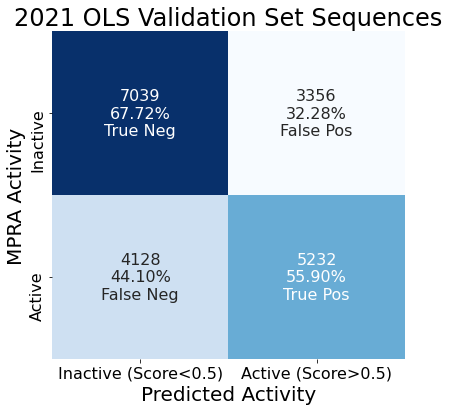

In [64]:
project_utils.cf_plot_from_df(data, label_col="MPRA_FXN", title="2021 OLS Validation Set Sequences", ylab="MPRA Activity")

## <u> **Correlation w/ activity** </u>

0.3021227836939955 0.0


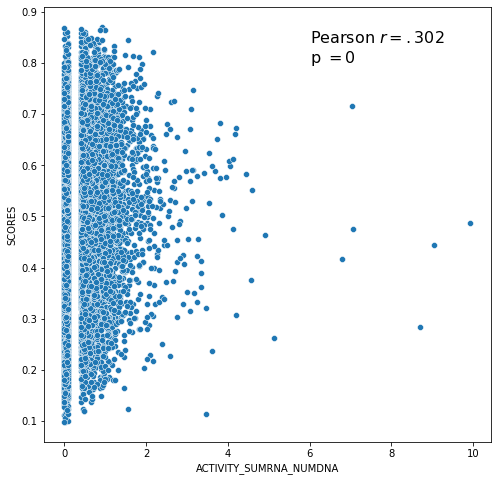

In [65]:
# Plot scatter
fig, ax = plt.subplots(1, 1, figsize=(8,8))
#sns.regplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", x_jitter=.5, ax=ax)
sns.scatterplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", ax=ax)

# Add pearson
no_na = (~data["ACTIVITY_SUMRNA_NUMDNA"].isna())
r, p = stats.spearmanr(data[no_na]["ACTIVITY_SUMRNA_NUMDNA"], data[no_na]["SCORES"])
print(r, p)
ax.annotate(r'Pearson $r = .302$' + '\n' + r'p $=0$', (6, 0.8), fontsize=16);

## <u> **Threshold plot** </u>

8it [00:02,  3.34it/s]


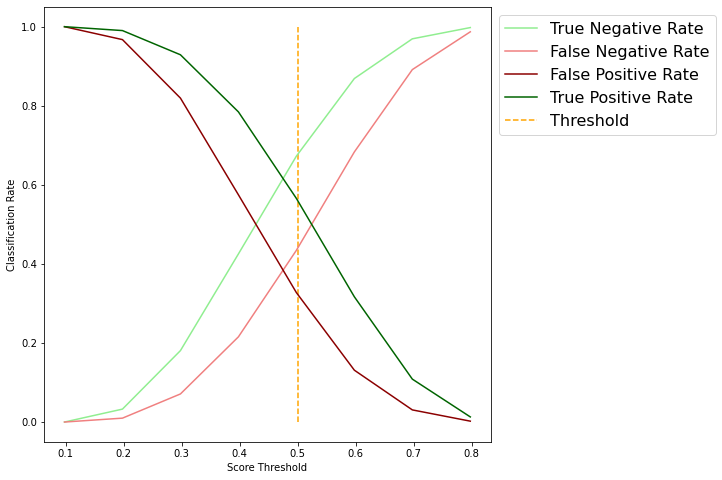

In [79]:
project_utils.threshold_plot(data, label_col="MPRA_FXN")

## <u> **Score distribution plot** </u>

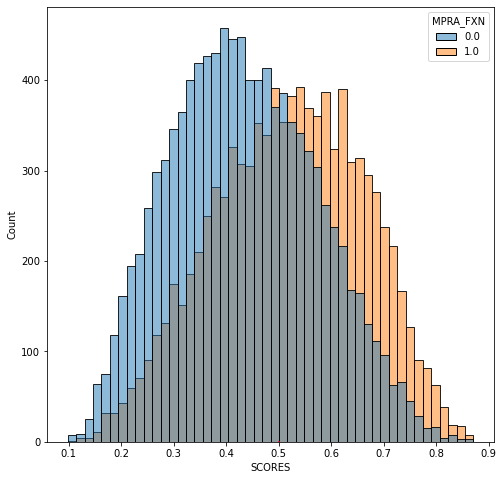

In [82]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
sns.histplot(data=data, x="SCORES", hue="MPRA_FXN", ax=ax);
ax.vlines(0.5, 0, 1, color="red", linestyle="dashed", label="Threshold");

# Evaluate on holdout sequences

In [27]:
X_holdout = np.load("../data/{}/{}/{}_X-holdout_{}.npy".format(TRAIN_DATASET, FEATURES.replace("-", "_"), PREPROCESS, FEATURES))
id_holdout = np.loadtxt("../data/{}/id/{}_id-holdout.txt".format(TRAIN_DATASET, PREPROCESS), dtype=str)
y_holdout_preds = clf.predict(X_holdout)
y_holdout_probs = clf.predict_proba(X_holdout)
clf_holdout_df = pd.DataFrame(data={"NAME": id_holdout, "PREDS": y_holdout_preds, "SCORES": y_holdout_probs[:, 1]})
holdout_df = pd.merge(OLS_dataset, clf_holdout_df, on="NAME")

## Microscope sequences

In [59]:
microscope_mask = (~holdout_df["MICROSCOPE_FXN"].isna())
microscope_df = holdout_df[microscope_mask]
microscope_df["microscope_label"] = (~(microscope_df["MICROSCOPE_FXN"] == "Non-Functional")).astype(int)
data = microscope_df
microscope_colors = dict(zip(data["MICROSCOPE_FXN"].unique(), ["darkgreen", "lightgreen", "gold", "red"]))
data["microscope_label"].value_counts()

<ipython-input-59-764356113563>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  microscope_df["microscope_label"] = (~(microscope_df["MICROSCOPE_FXN"] == "Non-Functional")).astype(int)


1    52
0    26
Name: microscope_label, dtype: int64

### <u> **Confusion matrix** </u>

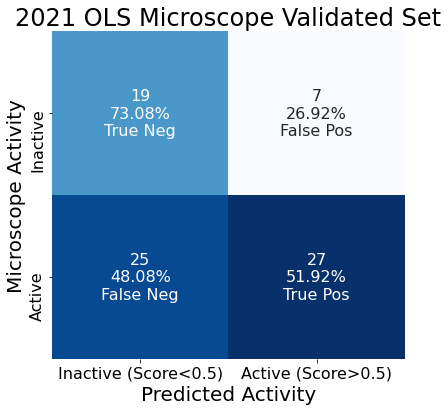

In [60]:
project_utils.cf_plot_from_df(data, label_col="microscope_label", title="2021 OLS Microscope Validated Set", ylab="Microscope Activity")

### <u> **Activity boxplot grouped by function** </u>

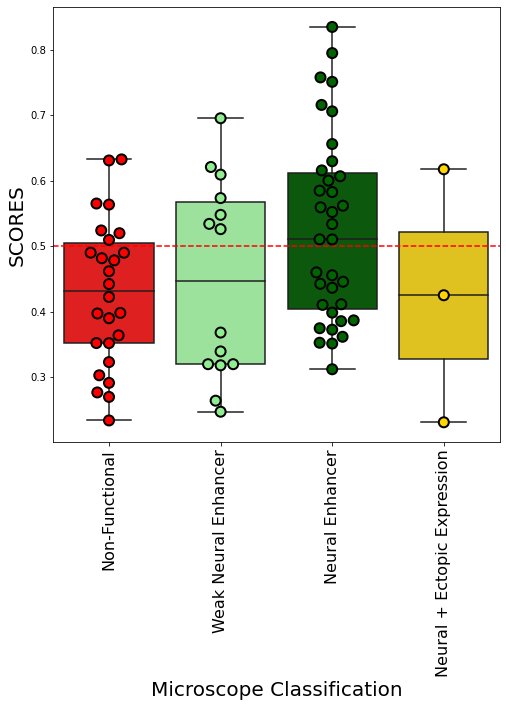

In [32]:
microscope_order = ['Non-Functional', 'Weak Neural Enhancer', 'Neural Enhancer', 'Neural + Ectopic Expression']
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.boxplot(y=data["SCORES"], x=data["MICROSCOPE_FXN"], order=microscope_order, palette=microscope_colors, ax=ax)
sns.swarmplot(y=data["SCORES"], x=data["MICROSCOPE_FXN"], order=microscope_order, palette=microscope_colors, size=10, edgecolor="black", linewidth=2, ax=ax)
ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16);
ax.set_xlabel("Microscope Classification", fontsize=20)
ax.set_ylabel("SCORES", fontsize=20);

### <u> **Swarmplot of scores** </u>

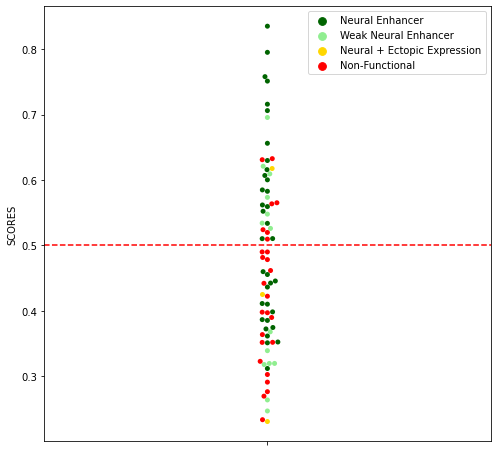

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.swarmplot(y=data["SCORES"], hue=data["MICROSCOPE_FXN"], x=[""]*len(data), palette=microscope_colors, ax=ax)
plt.legend(bbox_to_anchor=(1,1))
ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed");

### <u> **Scatterplot with activity** </u>

0.14746945928259525 0.19759117429200837


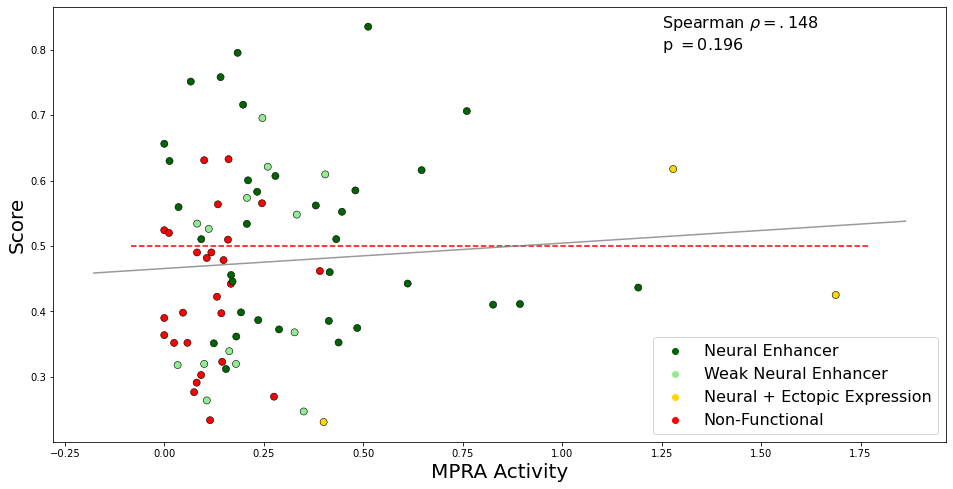

In [38]:
m, b = np.polyfit(data["ACTIVITY_SUMRNA_NUMDNA"], data["SCORES"], 1)

fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.scatterplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", hue="MICROSCOPE_FXN", palette=microscope_colors, s=50, edgecolor="black", ax=ax)
ax.hlines(0.5, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed");
ax.set_xlabel("MPRA Activity", fontsize=20)
ax.set_ylabel("Score", fontsize=20);
ax.legend(title='Microscope Classification', fontsize=16)

# Add trendline
x=np.arange(ax.get_xlim()[0], ax.get_xlim()[1], 0.01)
ax.plot(x, m*x + b, '-', color = "grey", alpha=0.8)
ax.legend(loc="lower right", fontsize=16)

# Add pearson
no_na = (~data["ACTIVITY_SUMRNA_NUMDNA"].isna())
r, p = stats.spearmanr(data[no_na]["ACTIVITY_SUMRNA_NUMDNA"], data[no_na]["SCORES"])
print(r, p)
ax.annotate(r'Spearman $\rho = .148$' + '\n' + r'p $=0.196$', (1.25, 0.8), fontsize=16);

## No label sequences

In [39]:
ambiguous_df = holdout_df[~microscope_mask]
data = ambiguous_df

0.0991791883979643 0.0


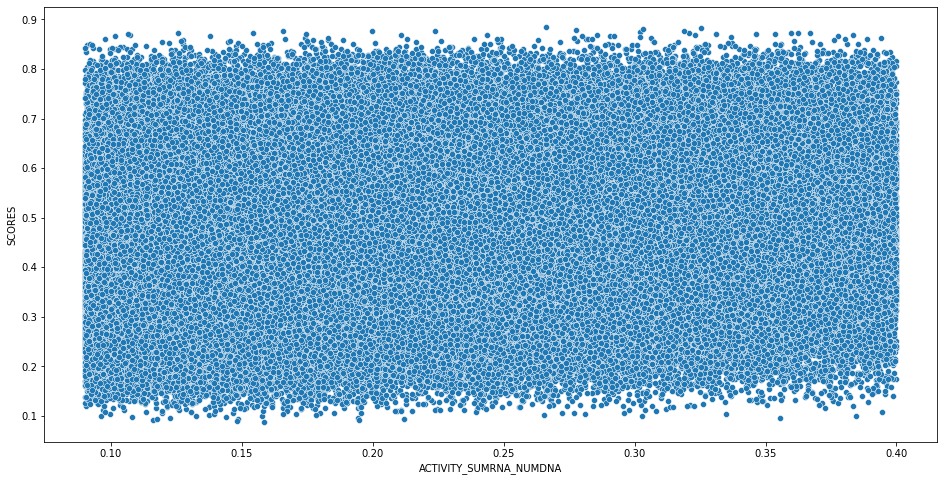

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.scatterplot(data=ambiguous_df, x="ACTIVITY_SUMRNA_NUMDNA", y="SCORES", ax=ax)
no_na = (~ambiguous_df["ACTIVITY_SUMRNA_NUMDNA"].isna())
p, r = stats.pearsonr(ambiguous_df[no_na]["ACTIVITY_SUMRNA_NUMDNA"], ambiguous_df[no_na]["SCORES"])
print(p, r)

# Evaluate on genomic sequences

## Full sequences

In [47]:
# Load genomic sequences
X_genomic = np.load("../data/All_Genomic_Sequences/mixed/{}_{}-split_X-test_{}.npy".format(PREPROCESS, SPLIT, FEATURES))
y_genomic = np.loadtxt("../data/All_Genomic_Sequences/{0}/y_{0}.txt".format(LABELS))
id_genomic = np.loadtxt("../data/All_Genomic_Sequences/id/id.txt", dtype=str)
valid_idx = np.loadtxt("../data/All_Genomic_Sequences/mixed/id-valid.txt", dtype=str)
valid_indices = np.where(np.in1d(id_genomic, valid_idx))[0]
genomic_dataset = pd.read_csv("../data/All_Genomic_Sequences/All_Genomic_Sequences.tsv", sep="\t").loc[valid_indices]

# Make predictions on sequences
y_genomic_preds = clf.predict(X_genomic)
y_genomic_probs = clf.predict_proba(X_genomic)[:, 1]
genomic_dataset["PREDS"] = y_genomic_preds
genomic_dataset["SCORES"] = y_genomic_probs

# Set data variable
data = genomic_dataset

### <u> **Confusion matrix** </u>

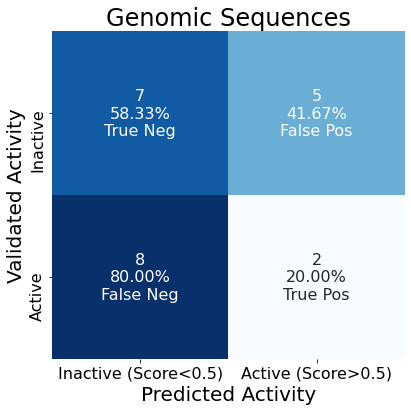

In [54]:
project_utils.cf_plot_from_df(data, title="Genomic Sequences", ylab="Validated Activity")

### <u> **Feature importances** </u>

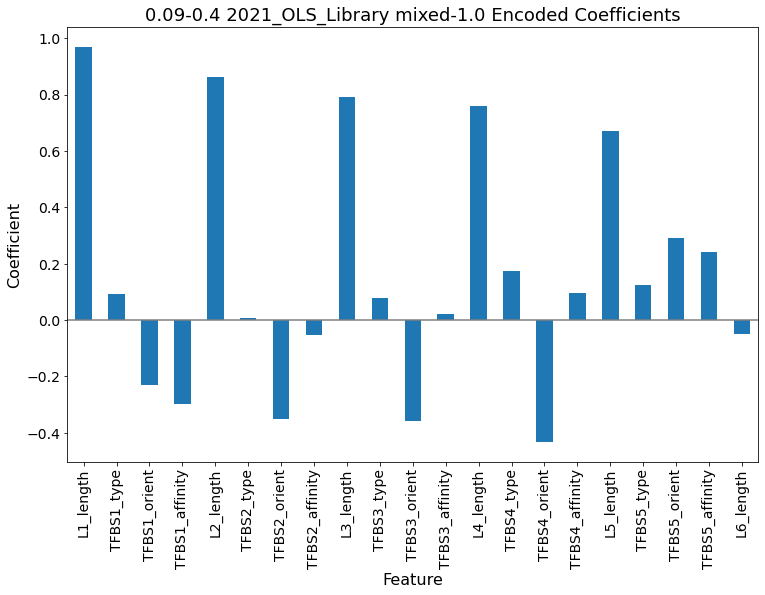

In [114]:
feature_names = pd.read_csv("../data/2021_OLS_Library/mixed_1.0/mixed-1.0_header.txt", header=None)[0]
project_utils.coefficient_plot(clf, feature_names, title="{} {} {} Encoded Coefficients".format(PREPROCESS, TRAIN_DATASET, FEATURES))

## Tiled Sequences

In [119]:
# Load genomic sequences
X_genomic = np.load("../data/All_Genomic_Sequences/mixed/{}_{}-split_X-test_{}-tiled.npy".format(PREPROCESS, SPLIT, FEATURES))
y_genomic = np.loadtxt("../data/All_Genomic_Sequences/{0}/y-tiled_{0}.txt".format(LABELS))
id_genomic = np.loadtxt("../data/All_Genomic_Sequences/id/id-tiled.txt", dtype=str)
valid_idx = np.loadtxt("../data/All_Genomic_Sequences/mixed/id-valid-tiled.txt", dtype=str)
valid_indices = np.where(np.in1d(id_genomic, valid_idx))[0]
genomic_dataset = pd.read_csv("../data/All_Genomic_Sequences/All_Genomic_Sequences-tiled.tsv", sep="\t").loc[valid_indices]

# Make predictions on sequences
y_genomic_preds = clf.predict(X_genomic)
y_genomic_probs = clf.predict_proba(X_genomic)[:, 1]
genomic_dataset["PREDS"] = y_genomic_preds
genomic_dataset["SCORES"] = y_genomic_probs

# Set data variable
data = genomic_dataset[genomic_dataset["TILE"].str.lower() != "full"]

### <u> **Tile plot** </u>

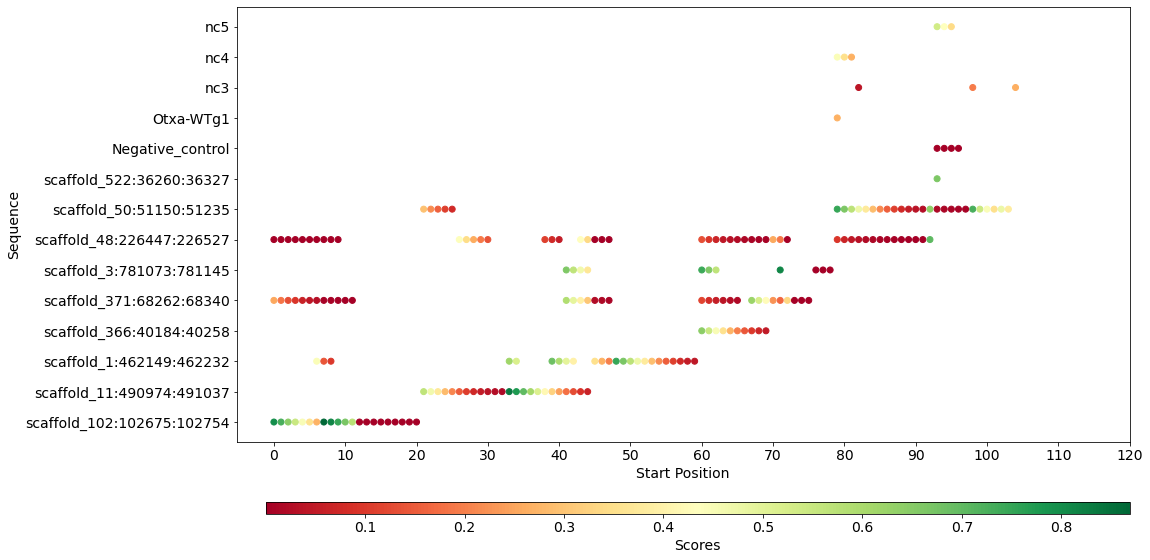

In [299]:
otx_enhancer_utils.tile_plot(data)

### <u> **Sequence tracks** </u>

In [239]:
cmap = mpl.cm.RdYlGn
norm = mpl.colors.Normalize(vmin=data["SCORES"].min(), vmax=data["SCORES"].max())

No importance scores given, outputting just sequence


{14: ['GATA', 'F', 'AAGATAGC', 0.5298185004564907, 12, 'G3F', 'AAGATAGG', 1],
 33: ['GATA', 'R', 'GCTATCCA', 0.10492969260849451, 11, 'G1R', 'GTTATCTC', 3],
 34: ['ETS', 'R', 'CTATCCAT', 0.08895921597696749, -7, 'E2R', 'ATTTCCTT', 3],
 47: ['ETS', 'F', 'GGGGAAGG', 0.11966139247634397, 5, 'E1F', 'ACGGAAGT', 3],
 52: ['ETS', 'F', 'AGGGAAAG', 0.10307605359238092, -3, 'E2F', 'AAGGAAAT', 2]}

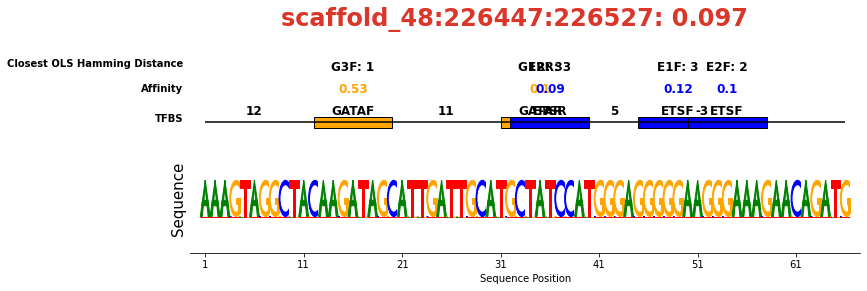

In [242]:
test = data[data["NAME"] == "scaffold_48:226447:226527"]
seqs = test["SEQ"].apply(str.upper).values
names = test["NAME"].values
scores = test["SCORES"].values
otx_enhancer_utils.otxGenomeTracks(seqs[0], seq_name=names[0], model_pred=scores[0], cmap=cmap, norm=norm)
otx_enhancer_utils.defineTFBS(seqs[0])

# Scratch

In [50]:
def cf_plot_from_df(data, label_col="FXN_LABEL", pred_col="PREDS", title="Sequences", xlab="Predicted Activity", ylab="True Activity", threshold=0.5):
    fig, ax = plt.subplots(1,1,figsize=(6,6))
    rc = {"font.size": 16}
    with plt.rc_context(rc):
        cf_names = ["True Neg","False Pos", "False Neg","True Pos"]
        cf_mtx = confusion_matrix(data[label_col], data[pred_col])
        cf_pcts = ["{0:.2%}".format(value) for value in (cf_mtx/cf_mtx.sum(axis=1)[:,None]).flatten()]
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(cf_mtx.flatten(),cf_pcts, cf_names)]
        labels = np.asarray(labels).reshape(2,2)
        sns.heatmap(cf_mtx, annot=labels, fmt='s', cmap='Blues', cbar=False, ax=ax)
        ax.set_xlabel(xlab, fontsize=20)
        ax.set_ylabel(ylab, fontsize=20)
        ax.set_title(title, fontsize=24)
        ax.set_yticklabels(["Inactive", "Active"], fontsize=16)
        ax.set_xticklabels(["Inactive (Score<{})".format(str(threshold)), "Active (Score>{})".format(str(threshold))], fontsize=16)
        plt.tight_layout();

In [ ]:
def threshold_plot(data, label_col="FXN_LABEL", score_col="SCORES", threshold=0.5):
    tns, fps, fns, tps = [], [], [], []
    threshs = np.arange(data[score_col].min(), data[score_col].max(), 0.1)
    for i, thresh in tqdm.tqdm(enumerate(threshs)):
        data["curr_pred"] = (data[score_col] >= thresh).astype(int)
        data["curr_class"] = ["-".join(list(value)) for value in data[["MPRA_FXN", "curr_pred"]].values.astype(str)]
        data["curr_class"] = data["curr_class"].replace({"0.0-0.0": "TN", "1.0-0.0": "FN", "0.0-1.0": "FP", "1.0-1.0": "TP"})

        class_results = data["curr_class"].value_counts()
        if "TN" in class_results:
            tns.append(class_results["TN"])
        else:
            tns.append(0)

        if "FP" in class_results:
            fps.append(class_results["FP"])
        else:
            fps.append(0)

        if "FN" in class_results:
            fns.append(class_results["FN"])
        else:
            fns.append(0)

        if "TP" in class_results:
            tps.append(class_results["TP"])
        else:
            tps.append(0)

    nb_negs = (data[label_col] == 0).sum()
    nb_pos = (data[label_col] == 1).sum()
    if (not (np.array([tns, fps, fns, tps]).sum(axis=0) == len(data)).all()) or (not (len(tns) == len(fps) == len(fns) == len(tps) == len(threshs))):
        print("Something rotten in Denmark")

    fig, ax = plt.subplots(1,1, figsize=(8,8))
    plt.plot(threshs, tns/nb_negs, color="lightgreen", label="True Negative Rate")
    plt.plot(threshs, fns/nb_pos, color="lightcoral", label="False Negative Rate")
    plt.plot(threshs, fps/nb_negs, color="darkred", label="False Positive Rate")
    plt.plot(threshs, tps/nb_pos, color="darkgreen", label="True Positive Rate")
    plt.vlines(threshold, 0, 1, color="orange", linestyle="dashed", label="Threshold")
    plt.legend(bbox_to_anchor=(1,1), fontsize=16)
    plt.xlabel("Score Threshold")
    plt.ylabel("Classification Rate")

In [111]:
def coefficient_plot(classifier, features, xlab="Feature", ylab="Coefficient", title="Model Coefficients"):
    rc = {"font.size": 14}
    with plt.rc_context(rc):
        coefs = pd.DataFrame(clf.coef_[0], columns=["Coefficients"], index=features)
        coefs.plot(kind="bar", figsize=(16, 8), legend=None)
        plt.title(title, fontsize=18)
        plt.axhline(y=0, color=".5")
        plt.subplots_adjust(left=0.3)
        plt.xlabel(xlab, fontsize=16)
        plt.ylabel(ylab, fontsize=16)

In [ ]:
def tile_plot(data, tile_col="TILE", score_col="SCORES", name_col="NAME"):
    rc = {"font.size": 14}
    with plt.rc_context(rc):
        fig, ax = plt.subplots(1, 1, figsize=(16,8))
        cmap = mpl.cm.RdYlGn
        plt.scatter(x=data[tile_col], y=data[name_col], c=data[score_col], cmap=cmap)
        cax = fig.add_axes([0.15, 0.0, 0.75, 0.02])
        norm = mpl.colors.Normalize(vmin=data[score_col].min(), vmax=data[score_col].max())
        cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
        cb.set_label("Scores")
        ax.set_ylabel("Sequence")
        ax.set_xlabel("Start Position")
        start, end = data[tile_col].astype(int).min(), data[tile_col].astype(int).max()
        ax.xaxis.set_ticks(np.arange(start, end, 10))
        ax.set_xticklabels(np.arange(start, end, 10))

## Block feature importance plotting

In [182]:
ohe = OneHotEncoder(sparse=False)
X = dataframe[block_features]
ohe.fit(X)

OneHotEncoder(sparse=False)

In [256]:
block = [block_features[0]]*5 + \
[block_features[1]]*10 + \
[block_features[2]]*5 + \
[block_features[3]]*10 + \
[block_features[4]]*5 + \
[block_features[5]]*10 + \
[block_features[6]]*5 + \
[block_features[7]]*10 + \
[block_features[8]]*5 + \
[block_features[9]]*10 + \
[block_features[10]]*5

In [261]:
tuples = list(zip(block, np.concatenate(ohe.categories_)[:-1]))
feature_names = pd.MultiIndex.from_tuples(tuples, names=["block", "feature"])

coefs = pd.DataFrame(
    clf.coef_[0],
    columns=["Coefficients"],
    index=feature_names,
)

coefs

Coefficients
block    feature              
linker_1 S1           0.193385
         S2          -0.280192
         S3           0.013604
         S4          -0.191411
         S5          -0.068216
...                        ...
TFBS_5   G1R         -0.180606
         G2F         -0.342247
         G2R         -0.144437
         G3F          0.085824
         G3R         -0.070173

[75 rows x 1 columns]

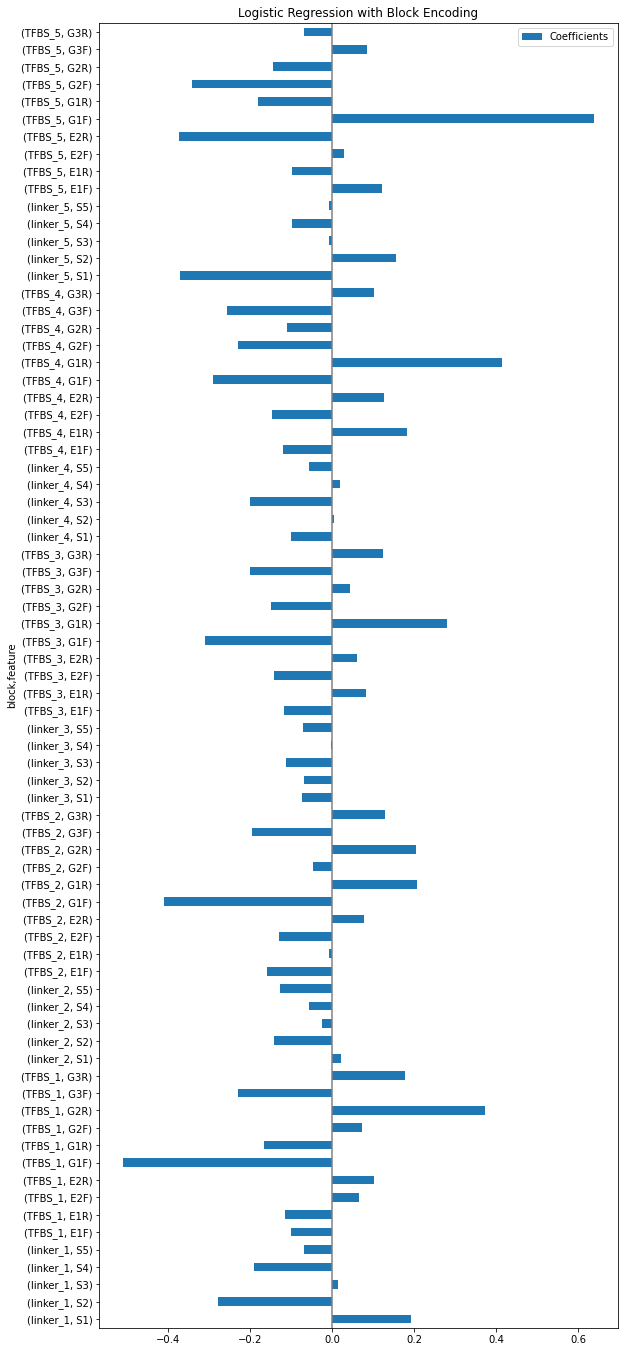

In [263]:
coefs.plot(kind="barh", figsize=(12, 24))
plt.title("Logistic Regression with Block Encoding")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

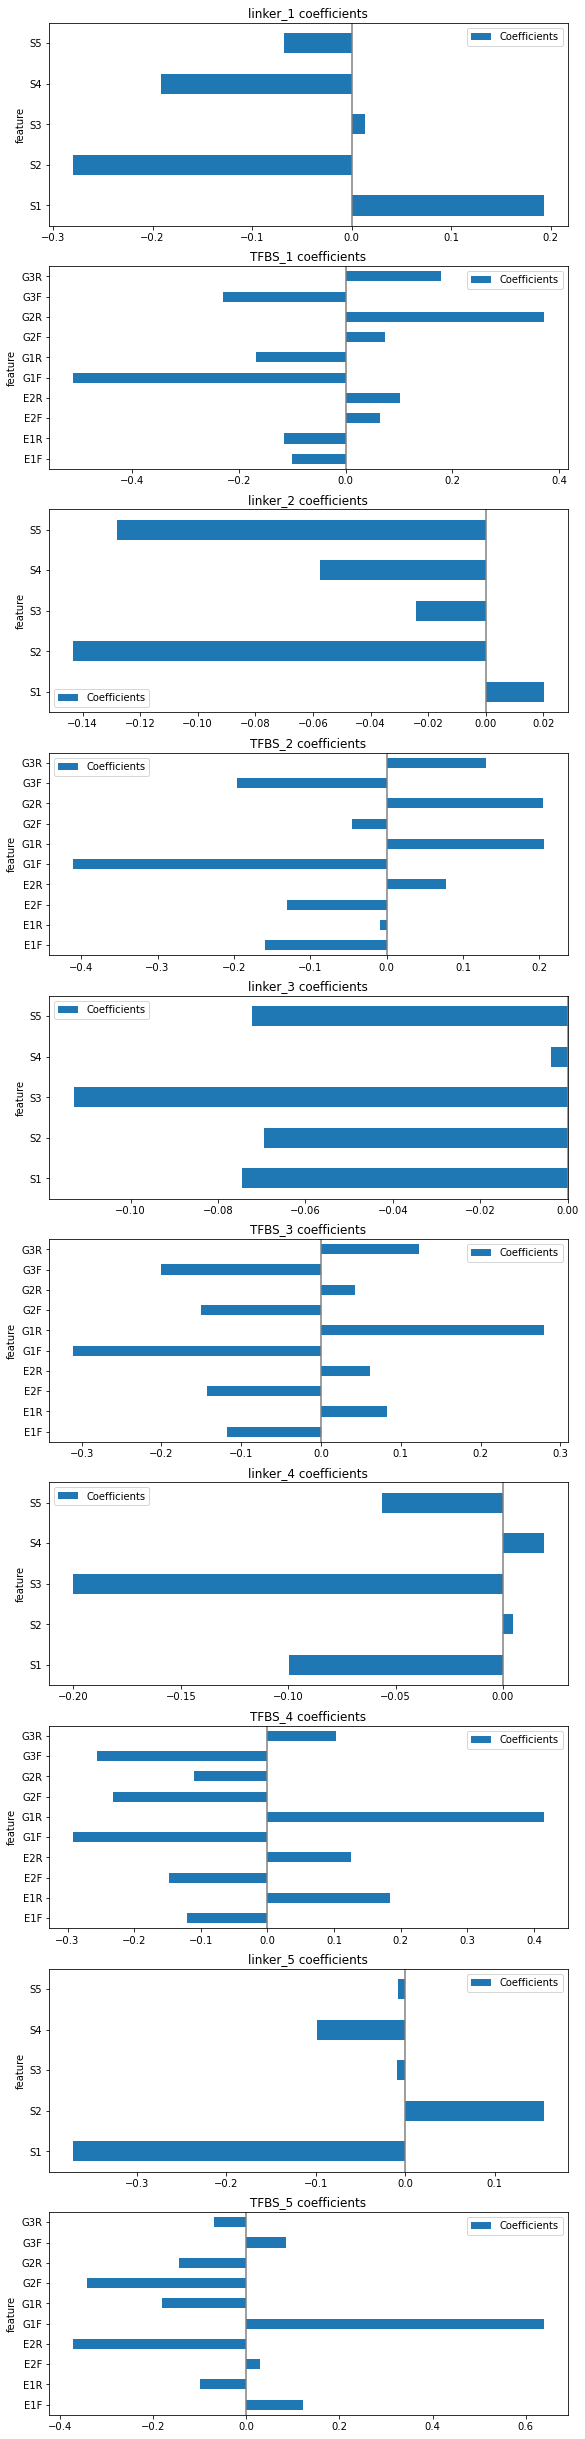

In [279]:
fix, ax = plt.subplots(len(coefs.index.get_level_values(0).unique()), 1, figsize=(12,44))
for i, blk in enumerate(coefs.index.get_level_values(0).unique()):
    coefs.loc[blk].plot(kind="barh", ax=ax[i])
    ax[i].set_title("{} coefficients".format(blk))
    ax[i].axvline(x=0, color=".5")
    plt.subplots_adjust(left=0.3)